## **UNCERTAINTY**


In this notebook we consider three problems:

* Prediction with bayes
* Calculation of size effects for the difference of the posterior means
* Hierarchical predictive modelling.

*******************************************

Libraries that we can use:

* **PyStan**:
* **PyMC3**: 
* **ArviZ:** this help us interpret and visualize posterior distributions obtained with PyMC3. 

*******************************************

**BASICS:**

Bayes Theorem:

![alt text](fig/bayes.png "Title")

Here, we replace H with hypothesis and D with data, Bayes' theorem tells us how to compute the probability of a hypothesis H given the data D. Where:

![alt text](fig/bayes_details.png "Title")

This means:

* **The prior distribution** should reflect what we know about the value of some parameter before seeing the data D.

* **The likelihood** is how we will introduce data in our analysis. It is an expression of the plausibility of the data given the parameters.

* **The posterior distribution** is the result of the Bayesian analysis and reflects all that we know about a problem (given our data and model). The posterior is a probability distribution for the parameters in our model and not a single value. **This distribution is a balance of the prior and the likelihood**. There is a joke that says: A Bayesian is one who, vaguely expecting a horse, and catching a glimpse of a donkey, strongly believes he has seen a mule. One way to kill the mood after hearing this joke is to explain that **if the likelihood and priors are both vague you will get a posterior reflecting vague beliefs about seeing a mule rather than strong ones**. 

We can think of the posterior as the updated prior in the light of the data. In fact, the posterior of one analysis can be used as the prior of a new analysis after collecting new data. This makes Bayesian analysis particularly suitable for analyzing data that becomes available in sequential order. 

The last term is the **evidence**, also known as marginal likelihood. Formally, the evidence is the probability of observing the data averaged over all the possible values the parameters can take. Most of the time we will not care about the evidence, and we will think of it as a simple normalization factor. This will not be problematic since we will only care about the relative values of the parameters and not their absolute ones:

![alt text](fig/bayes_alt.png "Title")

**Concepts to have in consideration:**

* **Conjugate prior** of a likelihood is a prior that, when used in combination with the given likelihood, returns a posterior with the same functional form as the prior. For example: every time we use a beta distribution as prior and a binomial distribution as likelihood, we will get a beta as a posterior. The Gaussian distribution is the conjugate prior of itself. 

**STEPS TO SOLVE ANY BAYESIAN MODEL:**

* **Step 1:** Establish a belief about the data, including Prior and Likelihood functions.
* **Step 2:** Use the data and probability, in accordance with our belief of the data, to update our model, check that our model agrees with the original data.
* **Step 3:** Update our view of the data based on our model.

## **Instal packages**

In [1]:
#!pip install arviz
#!pip install pymc3

## **Load packages**

In [2]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

## **DATA**

Data from Renfe, that indicates the train ticket price for different destinations.

In [3]:
print('Running on PyMC3 v{}'.format(pm.__version__))
data = pd.read_csv('data/renfe_small.csv')

Running on PyMC3 v3.8


In [4]:
data.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
1,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
2,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
3,2019-04-24 06:21:57,SEVILLA,MADRID,2019-05-03 08:35:00,2019-05-03 15:26:00,LD-MD,34.35,Turista con enlace,Promo +
4,2019-04-19 21:13:55,VALENCIA,MADRID,2019-05-10 09:40:00,2019-05-10 11:20:00,AVE,45.30,Turista,Promo


In [5]:
#look for missing values
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

There are 12% of values in price column are missing, I decide to fill them with the mean of the respective fare types. Also fill the other two categorical columns with the most common values.

In [6]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

## **Density plots (KDE)**

* The KDE plot of the rail ticket price shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean. 
* Let’s assume that a Gaussian distribution is a proper description of the rail ticket price. Since we do not know the mean or the standard deviation, we must set priors for both of them.


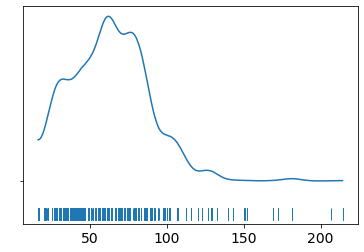

In [7]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);

## **Choices of priors for train ticket price**

This serves to choose all the possible values of the distribution that represents the function that we want to model.

* μ, mean of a population. Normal distribution, very wide. I do not know the possible values of μ, I can set priors reflecting my ignorance. From experience I know that train ticket price can not be lower than 0 or higher than 300, so I set the boundaries of the uniform distribution to be 0 and 300. You may have different experience and set the different boundaries. That is totally fine. And if you have more reliable prior information than I do, please use it!
* σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution. Again, very wide.

**Note:** we make this assumption for now, because we can assume other priors distribution for prices. We can consider a truncated Gaussian distribution to ensure that prices are positive. Another choice would be a Gamma distribution. The same thing for sigma, it is important to adequate adequate the priors to the information that you have. 

## **Choices of likelihood for train ticket price**

*  y specifies the likelihood. This is the way in which we tell PyMC3 that we want to condition for the unknown on the knows (data). In this case, y is an observed variable representing the data that comes from a normal distribution with the parameters μ and σ.

* Draw 1000 posterior samples using NUTS sampling.

## **MODEL**
Using **PyMC3**, we can write the model as follows:

In [8]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2451.44draws/s]


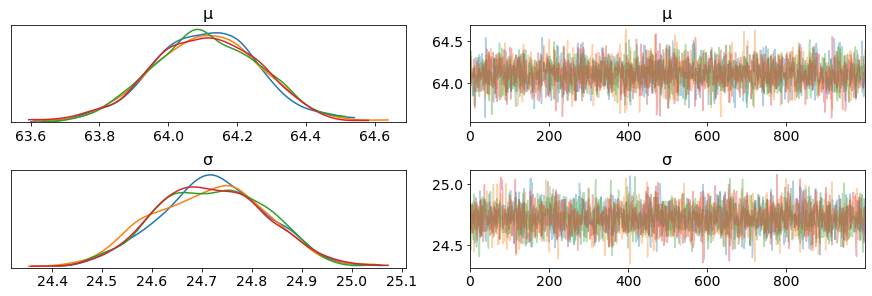

In [9]:
az.plot_trace(trace_g);

Here, we plot the joint distribution of the parameter

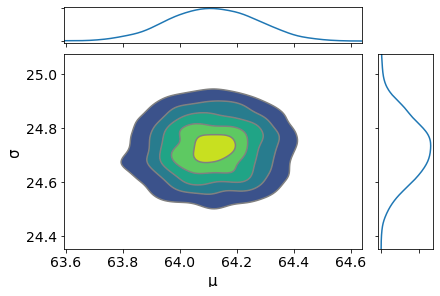

In [11]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

We can also have a detailed summary of the posterior distribution for each parameter.

In [14]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,64.11,0.154,63.816,64.393,0.003,0.002,3642.0,3642.0,3640.0,2848.0,1.0
σ,24.72,0.111,24.521,24.926,0.002,0.001,3465.0,3465.0,3452.0,2571.0,1.0


We can also see the above summary visually by generating a plot with the mean and Highest Posterior Density (HPD) of a distribution, and to interpret and report the results of a Bayesian inference.

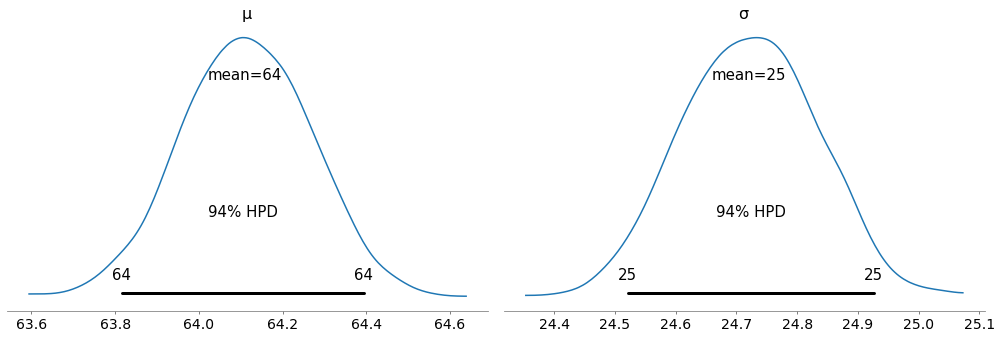

In [15]:
az.plot_posterior(trace_g);

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

In [16]:
pm.gelman_rubin(trace_g)

/Users/erikapat/anaconda3/lib/python3.7/site-packages/pymc3/stats/__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 0.9999
    σ        float64 1.001

Our model has converged well and the Gelman-Rubin statistic looks fine.

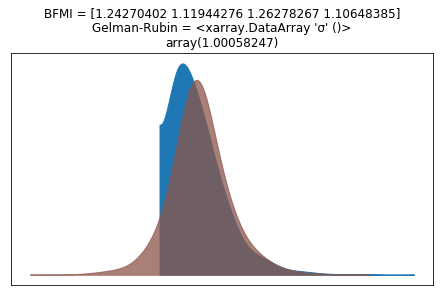

In [17]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

## **Posterior Predictive Checks**
* Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.
* Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.
* The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 25798 random numbers from a normal distribution specified by the values of μ and σ in that sample.

In [18]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape

/Users/erikapat/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 350.96it/s]


(1000, 25798)

Now, ppc contains 1000 generated data sets (containing 25798 samples each), each using a different parameter setting from the posterior.

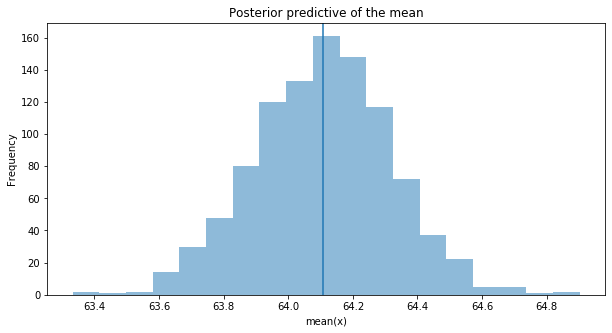

In [19]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

The inferred mean is very close to the actual rail ticket price mean.

## **Group Comparison**

We may be interested in how price compare under different fare types. We are going to focus on estimating the **effect size**, that is, quantifying the difference between two fare categories. For this we will work to obtain a **posterior distribution of the differences of means** between fare categories.

We create three variables:
* The price variable, representing the ticket price.
* The idx variable, a categorical dummy variable to encode the fare categories with numbers.
* And finally the groups variable, with the number of fare categories 

In [20]:
price = data['price'].values
idx = pd.Categorical(data['fare'],
                     categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
groups = len(np.unique(idx))

The model for the group comparison problem is almost the same as the previous model. the only difference is that μ and σ are going to be vectors instead of scalar variables. This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sd variables using the idx variable:

In [21]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price)

    trace_groups = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [02:21<00:00, 281.75draws/s]


In [22]:
flat_fares = az.from_pymc3(trace=trace_groups)
fares_gaussian = az.summary(flat_fares)
fares_gaussian

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],82.001,0.301,81.430,82.557,0.002,0.001,28021.0,28017.0,27994.0,15730.0,1.0
μ[1],62.426,0.160,62.126,62.727,0.001,0.001,27312.0,27306.0,27343.0,15473.0,1.0
μ[2],37.215,0.202,36.835,37.599,0.001,0.001,29352.0,29352.0,29336.0,15402.0,1.0
μ[3],31.122,0.135,30.862,31.372,0.001,0.001,26330.0,26318.0,26358.0,15587.0,1.0
μ[4],21.137,9.991,3.074,40.694,0.061,0.047,26855.0,22980.0,26849.0,15314.0,1.0
μ[5],18.485,9.878,0.282,37.137,0.062,0.048,25523.0,20974.0,25517.0,17086.0,1.0
σ[0],23.413,0.215,23.008,23.815,0.001,0.001,26032.0,26020.0,26088.0,16104.0,1.0
σ[1],21.426,0.113,21.216,21.635,0.001,0.000,27456.0,27456.0,27467.0,15625.0,1.0
σ[2],5.422,0.142,5.160,5.692,0.001,0.001,28035.0,27912.0,28152.0,16217.0,1.0
σ[3],5.692,0.095,5.514,5.871,0.001,0.000,28259.0,28238.0,28259.0,16106.0,1.0


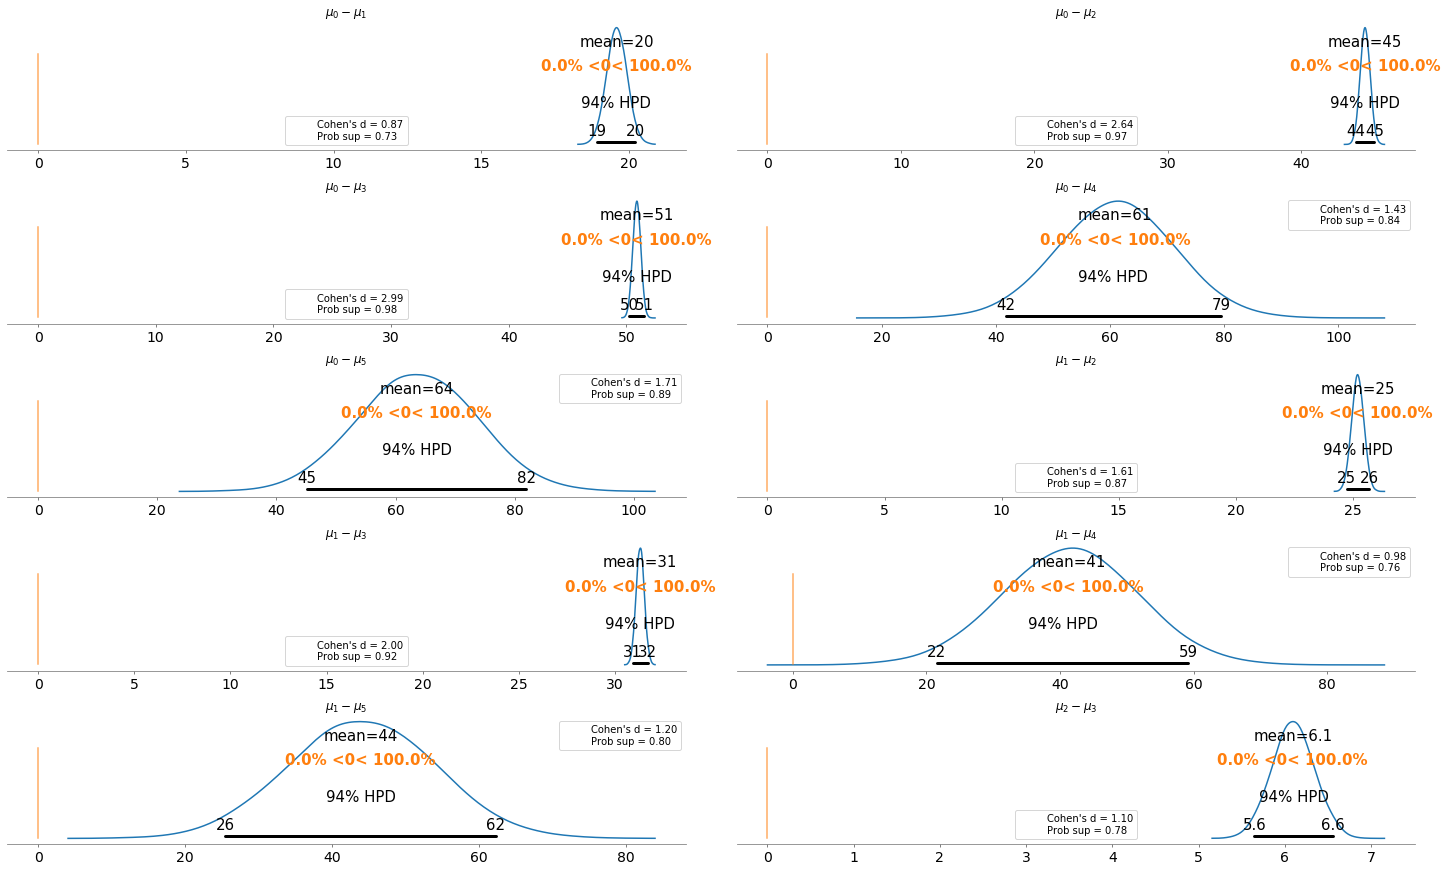

In [23]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_groups['μ'][:, i] - trace_groups['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['σ'][:, i]**2 + trace_groups['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

Basically, the above plot tells us that none of the above comparison cases where the 94% HPD includes the reference value of zero. This means for all the examples, we can rule out a difference of zero. The average differences range of 6.1 euro to 63.5 euro are large enough that it can justify for customers to purchase tickets according to different fare categories.

## **Bayesian Hierarchical Linear Regression**

We want to build a model to estimate the rail ticket price of each train type, and, at the same time, estimate the price of all the train types. **This type of model is known as a hierarchical model or multilevel model**.

The steps are:

* Encoding the categorical variable
* The idx variable, a categorical dummy variable to encode the train types with numbers.
* And finally the groups variable, with the number of train types (16)

In [25]:
def replace_fare(fare):
    
    if fare == 'Adulto ida':
        return 1
    elif fare == 'Promo +':
        return 2
    elif fare == 'Promo':
        return 3
    elif fare == 'Flexible':
        return 4
    elif fare == 'Individual-Flexible':
        return 5
    elif fare == 'Mesa':
        return 6

data['fare_encode'] = data['fare'].apply(lambda x: replace_fare(x))

label_encoder = preprocessing.LabelEncoder() 
data['train_type_encode']= label_encoder.fit_transform(data['train_type'])

train_type_names = data.train_type.unique()
train_type_idx = data.train_type_encode.values

n_train_types = len(data.train_type.unique())

data[['train_type', 'price', 'fare_encode']].head()

,train_type,price,fare_encode
0,ALVIA,82.077189,4
1,AVE,21.950000,3
2,AV City,38.550000,3
3,LD-MD,34.350000,2
4,AVE,45.300000,3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [07:48<00:00, 34.14draws/s]


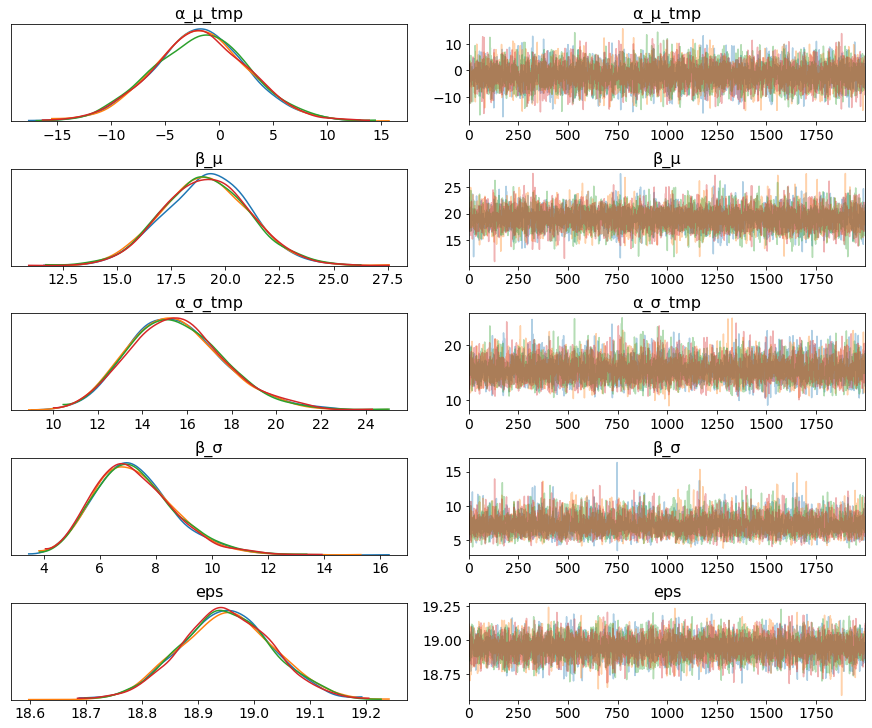

In [28]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    fare_est = α_tmp[train_type_idx] + β[train_type_idx]*data.fare_encode.values

    # Data likelihood
    fare_like = pm.Normal('fare_like', mu=fare_est, sd=eps, observed=data.price)
    
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)
    
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);

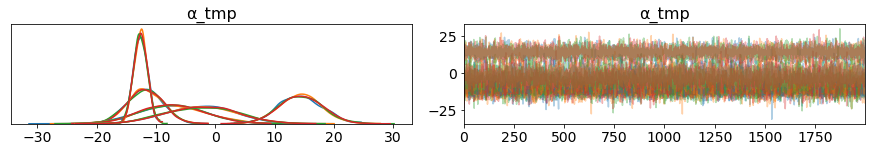

In [32]:
pm.traceplot(hierarchical_trace, var_names=['α_tmp'], coords={'α_tmp_dim_0': range(5)});

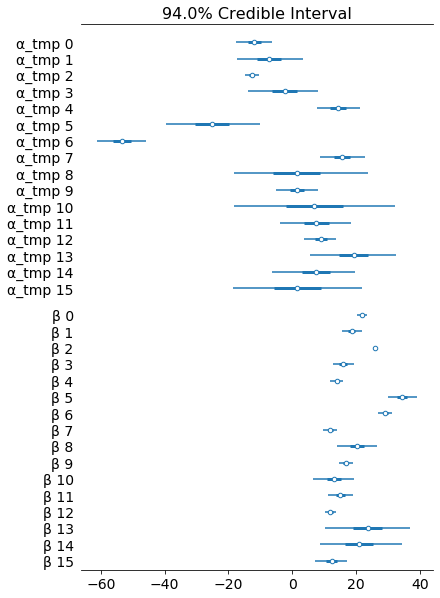

In [30]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True);

In [31]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(data.price.values, ppc['fare_like'])

/Users/erikapat/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:04<00:00, 487.00it/s]


r2        0.411977
r2_std    0.007707
dtype: float64

## **REFERENCES**

* Hands On Bayesian Statistics with Python, PyMC3 & ArviZ
[&lt;here&gt;](https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501)


In [ ]:
'''
erase
https://www.r-bloggers.com/data-visualization-with-statistical-reasoning-seeing-uncertainty-with-the-bootstrap/
* https://www.r-bloggers.com/statistics-sunday-converting-between-effect-sizes-for-meta-analysis/
''''